# Starbucks Capstone (predict next purchase time)

# Fixing a big mistake
We originally had such good results with classification models (about 99.5 percent accuracy) that we toyed with regression to see if we could pinpoint the hour of the customer's next purchase. It then dawned on us that perhaps the reason the classification model was so accurate was that we actually put it into a time machine so it could literally see the future.<br>

The features of our model, such as Recency, Frequency and Revenue, all were taken from the first 20 days of our 30-day timeline. The target variable then was derived by subtracting the hour of the last transaction in the first 20 days from the hour of the first transaction in the last 10 days.<br>

That next_purchase target variable, then, was the only variable that had any awareness of what happened in the last 10 days of our timeline. For classification, we converted our target variable into next_purchase_range, grouping the customers by the hour of their next purchase. We also left in the former target variable, next_purchase. So in trying to predict the range within which the customer would make his or her next purchase, the model already knew the hour of the next purchase.<br>

So while we have to backtrack, hopefully this narrows our focus on classification and gives us a clear path to the finish line of this project.

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [334]:
sb_class = pd.read_csv('sb_class.csv')

In [335]:
sb_class.head()

,Unnamed: 0,person,next_purchase,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,...,TimeDiffStd,age,member_time,income,gender_F,gender_M,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,next_purchase_range
0,0,00426fe3ffde4c6b9cb9ad6d077a13ea,138.0,126,2,13,3,60.67,0,5,...,23.073007,19,716,65000.0,1,0,0,0,1,0
1,1,04189492f0aa46f2b6fefe34ffbc7062,108.0,66,2,12,3,45.07,0,5,...,16.815577,29,1685,64000.0,0,1,0,0,1,0
2,2,093f0c09cc7242228edbb0e52ca14af6,78.0,72,2,14,3,33.82,0,5,...,28.863072,36,404,35000.0,0,1,0,0,1,1
3,3,0b6c775f84a8435a9083900e1cb43ec9,90.0,72,2,15,3,39.69,0,5,...,21.105699,27,259,35000.0,0,1,0,0,1,1
4,4,1280b4c8aa2a47dbbc1a7c79d0c9484d,102.0,72,2,11,3,49.97,0,5,...,40.024992,48,1526,42000.0,0,1,0,0,1,0


In [336]:
sb_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9130 entries, 0 to 9129
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           9130 non-null   int64  
 1   person               9130 non-null   object 
 2   next_purchase        9130 non-null   float64
 3   Recency              9130 non-null   int64  
 4   RecencyCluster       9130 non-null   int64  
 5   Frequency            9130 non-null   int64  
 6   FrequencyCluster     9130 non-null   int64  
 7   Revenue              9130 non-null   float64
 8   RevenueCluster       9130 non-null   int64  
 9   OverallScore         9130 non-null   int64  
 10  TimeDiff             9130 non-null   float64
 11  TimeDiff2            9130 non-null   float64
 12  TimeDiff3            9130 non-null   float64
 13  TimeDiffMean         9130 non-null   float64
 14  TimeDiffStd          9130 non-null   float64
 15  age                  9130 non-null   i

In [337]:
sb_class.drop(columns = ['Unnamed: 0'], inplace = True)

# Histogram
Let's look at a histogram of all the features. It looks like RecencyCluster and RevenueCluster have unbalanced classes. We'll take a closer look at those.

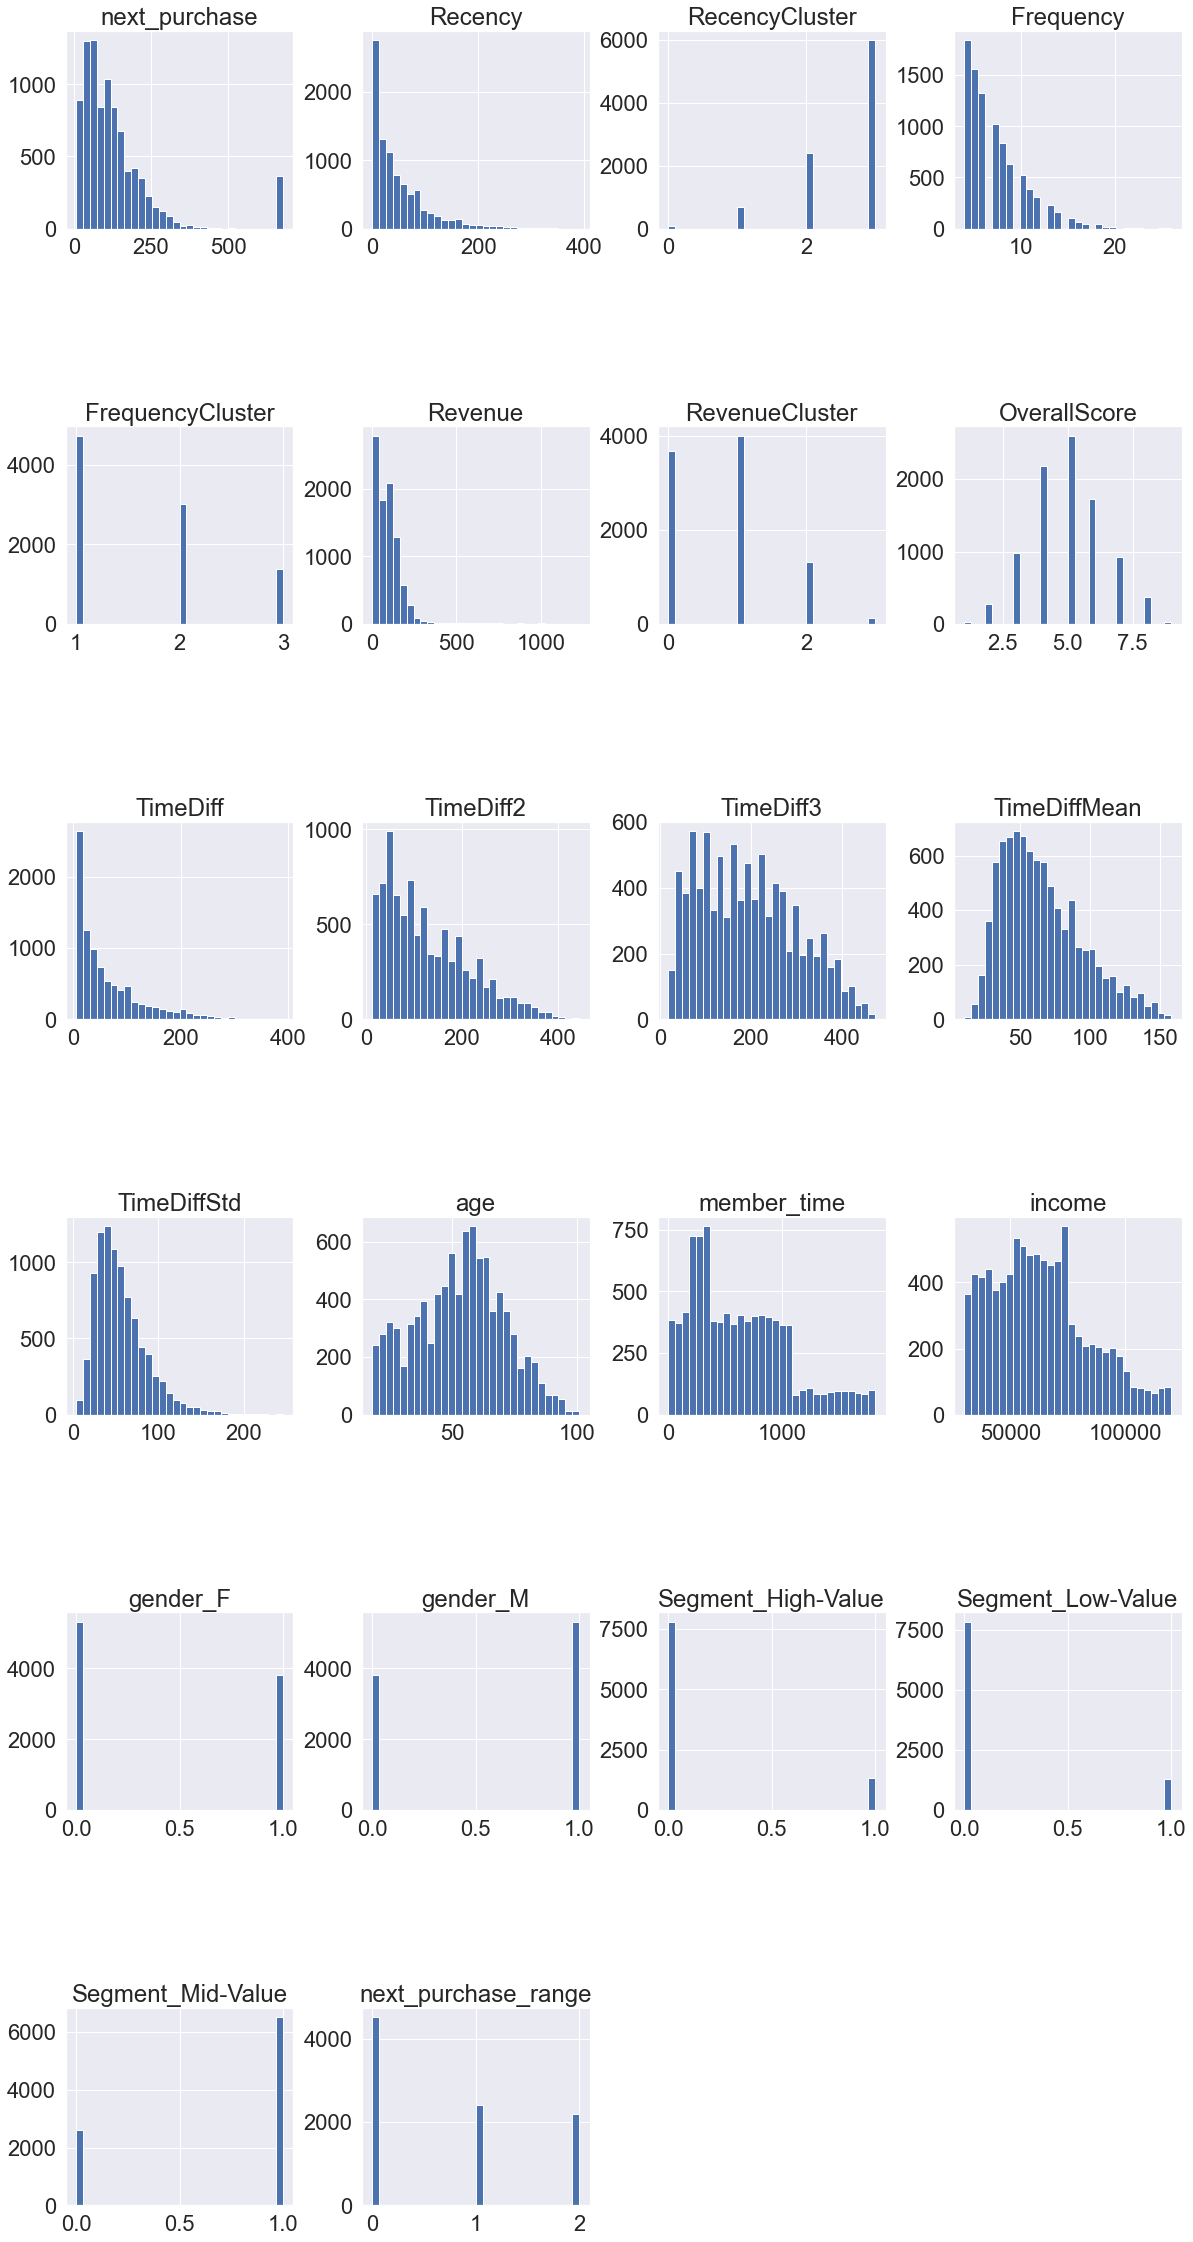

In [338]:
sb_class.hist(layout=(6, 4), figsize=(20,40), bins = 30)
plt.subplots_adjust(hspace=1)
plt.show()

These next few cells will show that customer recency is one thing we have going for us while those high-revenue customers really are in an elite class.

In [339]:
sb_class['RecencyCluster'].value_counts()

3    5982
2    2388
1     680
0      80
Name: RecencyCluster, dtype: int64

In [340]:
zero_recency = sb_class[sb_class['RecencyCluster'] == 0]

In [341]:
zero_recency.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 1322 to 8533
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               80 non-null     object 
 1   next_purchase        80 non-null     float64
 2   Recency              80 non-null     int64  
 3   RecencyCluster       80 non-null     int64  
 4   Frequency            80 non-null     int64  
 5   FrequencyCluster     80 non-null     int64  
 6   Revenue              80 non-null     float64
 7   RevenueCluster       80 non-null     int64  
 8   OverallScore         80 non-null     int64  
 9   TimeDiff             80 non-null     float64
 10  TimeDiff2            80 non-null     float64
 11  TimeDiff3            80 non-null     float64
 12  TimeDiffMean         80 non-null     float64
 13  TimeDiffStd          80 non-null     float64
 14  age                  80 non-null     int64  
 15  member_time          80 non-null     

In [342]:
zero_recency.describe()

,next_purchase,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,TimeDiff,TimeDiff2,...,TimeDiffStd,age,member_time,income,gender_F,gender_M,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,next_purchase_range
count,80.000000,80.000000,80.0,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0,80.000000,80.000000,80.0
mean,335.862500,275.475000,0.0,4.787500,1.112500,73.37700,0.637500,1.750000,44.925000,80.775000,...,32.692156,56.087500,521.775000,68312.500000,0.512500,0.487500,0.0,0.962500,0.037500,0.0
std,65.688514,31.216263,0.0,1.299403,0.317974,50.78719,0.641275,0.754732,38.150858,44.777361,...,17.800505,17.019121,370.115274,22946.604917,0.502997,0.502997,0.0,0.191182,0.191182,0.0
min,252.000000,246.000000,0.0,4.000000,1.000000,7.03000,0.000000,1.000000,6.000000,18.000000,...,6.000000,18.000000,30.000000,31000.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,294.000000,252.000000,0.0,4.000000,1.000000,19.99000,0.000000,1.000000,12.000000,48.000000,...,18.513207,45.750000,185.000000,49750.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0
50%,324.000000,264.000000,0.0,4.000000,1.000000,71.67000,1.000000,2.000000,30.000000,72.000000,...,28.782241,57.000000,363.500000,69500.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.0
75%,361.500000,288.000000,0.0,5.000000,1.000000,104.45750,1.000000,2.000000,72.000000,108.000000,...,42.035654,68.000000,769.250000,85500.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0
max,679.000000,390.000000,0.0,10.000000,2.000000,198.91000,2.000000,4.000000,156.000000,204.000000,...,80.572948,94.000000,1573.000000,119000.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0


In [343]:
best_recency = sb_class[sb_class['RecencyCluster'] == 3]

In [344]:
best_recency.describe()

,next_purchase,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,TimeDiff,TimeDiff2,...,TimeDiffStd,age,member_time,income,gender_F,gender_M,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,next_purchase_range
count,5982.000000,5982.000000,5982.0,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,...,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.0,5982.000000,5982.000000
mean,101.867603,19.224674,3.0,7.757606,1.748579,101.218572,0.794885,5.543464,59.829488,123.200602,...,56.876824,52.907222,650.588599,62099.799398,0.417419,0.582581,0.206787,0.0,0.793213,1.053327
std,128.170654,14.959121,0.0,3.315352,0.755945,103.322613,0.757874,1.149151,61.490523,90.728097,...,30.054278,17.855106,430.701387,20492.773284,0.493174,0.493174,0.405035,0.0,0.405035,0.821667
min,6.000000,0.000000,3.0,4.000000,1.000000,2.270000,0.000000,4.000000,6.000000,12.000000,...,3.464102,18.000000,0.000000,30000.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,36.000000,6.000000,3.0,5.000000,1.000000,35.410000,0.000000,5.000000,18.000000,48.000000,...,35.156792,40.000000,295.250000,46000.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
50%,66.000000,18.000000,3.0,7.000000,2.000000,85.905000,1.000000,5.000000,36.000000,96.000000,...,51.029403,54.000000,588.000000,60000.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.000000
75%,114.000000,30.000000,3.0,10.000000,2.000000,133.395000,1.000000,6.000000,78.000000,180.000000,...,71.655423,66.000000,926.000000,74000.000000,1.000000,1.000000,0.000000,0.0,1.000000,2.000000
max,679.000000,48.000000,3.0,26.000000,3.000000,1226.790000,3.000000,9.000000,390.000000,444.000000,...,246.024389,101.000000,1823.000000,120000.000000,1.000000,1.000000,1.000000,0.0,1.000000,2.000000


In [345]:
sb_class['RevenueCluster'].value_counts()

1    4007
0    3684
2    1322
3     117
Name: RevenueCluster, dtype: int64

In [346]:
high_revenue = sb_class[sb_class['RevenueCluster'] == 3]

In [347]:
high_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 3684 to 3800
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               117 non-null    object 
 1   next_purchase        117 non-null    float64
 2   Recency              117 non-null    int64  
 3   RecencyCluster       117 non-null    int64  
 4   Frequency            117 non-null    int64  
 5   FrequencyCluster     117 non-null    int64  
 6   Revenue              117 non-null    float64
 7   RevenueCluster       117 non-null    int64  
 8   OverallScore         117 non-null    int64  
 9   TimeDiff             117 non-null    float64
 10  TimeDiff2            117 non-null    float64
 11  TimeDiff3            117 non-null    float64
 12  TimeDiffMean         117 non-null    float64
 13  TimeDiffStd          117 non-null    float64
 14  age                  117 non-null    int64  
 15  member_time          117 non-null   

In [348]:
high_revenue.describe()

,next_purchase,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,TimeDiff,TimeDiff2,...,TimeDiffStd,age,member_time,income,gender_F,gender_M,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,next_purchase_range
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.0,117.000000,117.000000,117.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.0,117.000000,117.000000
mean,120.136752,40.256410,2.666667,8.410256,1.888889,747.882137,3.0,7.555556,58.051282,117.128205,...,52.535472,55.888889,594.111111,77393.162393,0.478632,0.521368,0.846154,0.0,0.153846,0.811966
std,124.894225,39.321433,0.557086,3.311823,0.763135,177.468282,0.0,1.003824,57.435698,86.373840,...,31.948544,16.345820,326.396965,19437.325125,0.501692,0.501692,0.362353,0.0,0.362353,0.829745
min,6.000000,0.000000,1.000000,4.000000,1.000000,479.870000,3.0,5.000000,6.000000,12.000000,...,8.485281,18.000000,37.000000,39000.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,48.000000,12.000000,2.000000,6.000000,1.000000,605.350000,3.0,7.000000,18.000000,48.000000,...,31.473694,46.000000,320.000000,64000.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
50%,90.000000,30.000000,3.000000,8.000000,2.000000,716.180000,3.0,8.000000,42.000000,84.000000,...,44.484931,57.000000,539.000000,72000.000000,0.000000,1.000000,1.000000,0.0,0.000000,1.000000
75%,156.000000,60.000000,3.000000,10.000000,2.000000,894.710000,3.0,8.000000,78.000000,174.000000,...,64.475909,67.000000,821.000000,94000.000000,1.000000,1.000000,1.000000,0.0,0.000000,2.000000
max,679.000000,210.000000,3.000000,20.000000,3.000000,1226.790000,3.0,9.000000,258.000000,444.000000,...,212.075458,94.000000,1752.000000,119000.000000,1.000000,1.000000,1.000000,0.0,1.000000,2.000000


In [349]:
sb_class.drop(columns = ['next_purchase'], inplace = True)

In [350]:
sb_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9130 entries, 0 to 9129
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               9130 non-null   object 
 1   Recency              9130 non-null   int64  
 2   RecencyCluster       9130 non-null   int64  
 3   Frequency            9130 non-null   int64  
 4   FrequencyCluster     9130 non-null   int64  
 5   Revenue              9130 non-null   float64
 6   RevenueCluster       9130 non-null   int64  
 7   OverallScore         9130 non-null   int64  
 8   TimeDiff             9130 non-null   float64
 9   TimeDiff2            9130 non-null   float64
 10  TimeDiff3            9130 non-null   float64
 11  TimeDiffMean         9130 non-null   float64
 12  TimeDiffStd          9130 non-null   float64
 13  age                  9130 non-null   int64  
 14  member_time          9130 non-null   int64  
 15  income               9130 non-null   f

# Modeling
We'll start with our original setup of three classes: 2=within 48 hours, 1=within 96 hours, 0=more than 96 hours. We expanded that to nine classes after getting such good results with three classes previously, but since we're going back to the drawing board let's start again with the three classes.

In [351]:
from sklearn.model_selection import train_test_split 

In [352]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [353]:
def make_Xy(target, df):
    X = df.drop(columns = ['person', target])
    y = df[target]
    return X, y

In [354]:
def scale(train, test):
    X_train = scaler.fit_transform(train)
    X_test = scaler.transform(test)
    return X_train, X_test

In [355]:
X, y = make_Xy('next_purchase_range', sb_class)

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [357]:
X_train, X_test = scale(X_train, X_test)

In [358]:
X_scaled_df = pd.DataFrame(X_train, columns = X.columns)

In [359]:
X_scaled_df.head(10)

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,TimeDiff,TimeDiff2,TimeDiff3,TimeDiffMean,TimeDiffStd,age,member_time,income,gender_F,gender_M,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,-0.936509,0.655437,4.330337,1.868422,-0.135200,0.309990,1.434385,-0.919887,-1.311438,-1.423161,-1.504283,-1.143378,-0.448961,0.552230,0.486453,-0.844089,0.844089,2.423230,-0.405375,-1.57751
1,-0.476142,0.655437,-0.079398,0.500913,-0.414501,-1.040484,0.024270,-0.144920,0.205595,-0.177942,-0.149505,-0.637902,0.397626,0.042158,-1.475825,-0.844089,0.844089,-0.412672,-0.405375,0.63391
2,-0.245959,0.655437,-0.709360,-0.866595,-0.364203,-1.040484,-0.680787,2.567464,1.446803,1.576686,1.375053,0.979725,0.454066,-0.952132,-0.901500,-0.844089,0.844089,-0.412672,-0.405375,0.63391
3,0.789866,-0.838997,0.865545,0.500913,0.035220,0.309990,0.024270,0.630047,-0.139185,-0.574148,-0.900234,-0.402499,-1.803501,1.584129,-0.805779,-0.844089,0.844089,-0.412672,-0.405375,0.63391
4,-0.476142,0.655437,0.550564,0.500913,-0.710764,-1.040484,0.024270,-0.532403,-0.897701,-0.630749,-0.392048,0.606833,0.736261,0.241956,-0.757919,-0.844089,0.844089,-0.412672,-0.405375,0.63391
5,-0.361050,0.655437,-0.394379,-0.866595,-0.414599,-1.040484,-0.680787,-0.726145,-1.173526,-0.517547,0.605844,1.748280,-1.577745,0.636851,-0.710058,-0.844089,0.844089,-0.412672,-0.405375,0.63391
6,1.020050,-0.838997,-0.394379,-0.866595,-0.770431,-1.040484,-1.385844,-0.048049,-0.346053,-0.064740,-0.142575,-0.669472,0.115431,0.881309,-0.470756,1.184709,-1.184709,-0.412672,2.466853,-1.57751
7,-0.591234,0.655437,-0.709360,-0.866595,-0.448526,-1.040484,-0.680787,2.276851,1.377847,0.897475,1.427027,0.806297,-1.859941,-0.785242,-0.805779,1.184709,-1.184709,-0.412672,-0.405375,0.63391
8,-0.130867,0.655437,-0.079398,0.500913,-0.183427,0.309990,0.729328,-0.823016,-1.173526,0.218265,-0.010909,0.683536,0.454066,0.481713,-1.045082,-0.844089,0.844089,-0.412672,-0.405375,0.63391
9,-0.015775,0.655437,-0.709360,-0.866595,-0.206308,0.309990,0.024270,1.501885,0.688287,0.048462,-0.288101,0.380337,-1.972819,0.629799,-0.662198,-0.844089,0.844089,-0.412672,-0.405375,0.63391


In [360]:
X_scaled_df.mean()

Recency              -4.795448e-17
RecencyCluster        3.050812e-16
Frequency            -2.541474e-16
FrequencyCluster     -3.055676e-17
Revenue              -1.012768e-16
RevenueCluster        4.176235e-16
OverallScore         -3.381568e-16
TimeDiff             -2.051463e-16
TimeDiff2             1.136194e-16
TimeDiff3             8.242854e-17
TimeDiffMean         -5.760444e-17
TimeDiffStd          -1.811170e-16
age                  -2.153739e-16
member_time          -2.536263e-17
income                1.643881e-16
gender_F              9.592633e-17
gender_M             -9.592633e-17
Segment_High-Value    2.653174e-16
Segment_Low-Value     3.935116e-16
Segment_Mid-Value    -5.317293e-16
dtype: float64

In [361]:
X_scaled_df.std()

Recency               1.000078
RecencyCluster        1.000078
Frequency             1.000078
FrequencyCluster      1.000078
Revenue               1.000078
RevenueCluster        1.000078
OverallScore          1.000078
TimeDiff              1.000078
TimeDiff2             1.000078
TimeDiff3             1.000078
TimeDiffMean          1.000078
TimeDiffStd           1.000078
age                   1.000078
member_time           1.000078
income                1.000078
gender_F              1.000078
gender_M              1.000078
Segment_High-Value    1.000078
Segment_Low-Value     1.000078
Segment_Mid-Value     1.000078
dtype: float64

In [362]:
model_lists = []

This function prints out the parts of the classification report we're most interested in.

In [363]:
def show_report(df):
    for i in range(3):
        precision = df.loc['precision', str(i)]
        recall = df.loc['recall', str(i)]
        f1score = df.loc['f1-score', str(i)]
        print()
        print(i, " class:")
        print(f"Precision: {precision:.5f}")
        print(f"Recall: {recall:.5f}")
        print(f"F1 Score: {f1score:.5f}")

# Gathering model metrics
This function collects classification report and confusion matrix information in a list so we can create a dataframe of our model results.<br>

There are three types of errors we most want to avoid, in this order:<br>

**Class 2 predicted as Class 0:** Customers who will come back in 2 days predicted as not coming back until at least 4 days.<br>
**Class 1 predicted as Class 0:** Customers who will come back in 2-4 days predicted as not coming back until at least 4 days.<br>
**Class 2 predicted as Class 1:** Customers who will come back in 2 days predicted as coming back in 2-4 days.<br>

In [364]:
def list_to_append(model, acc, df, c_matrix):
    new_list = []
    new_list.append(model)
    new_list.append(round(acc, 5))
    for i in range(3):
        new_list.append(round(df.loc['precision', str(i)], 5))
        new_list.append(round(df.loc['recall', str(i)], 5))
        new_list.append(round(df.loc['f1-score', str(i)], 5))
    new_list.append(round(c_matrix[2, 0], 5))
    new_list.append(round(c_matrix[1, 0], 5))
    new_list.append(round(c_matrix[2, 1], 5))
    return new_list

In [365]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [366]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [367]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.6020445418035779


0  class:
Precision: 0.69685
Recall: 0.78319
F1 Score: 0.73750

1  class:
Precision: 0.39931
Recall: 0.15562
F1 Score: 0.22395

2  class:
Precision: 0.50917
Recall: 0.73292
F1 Score: 0.60089


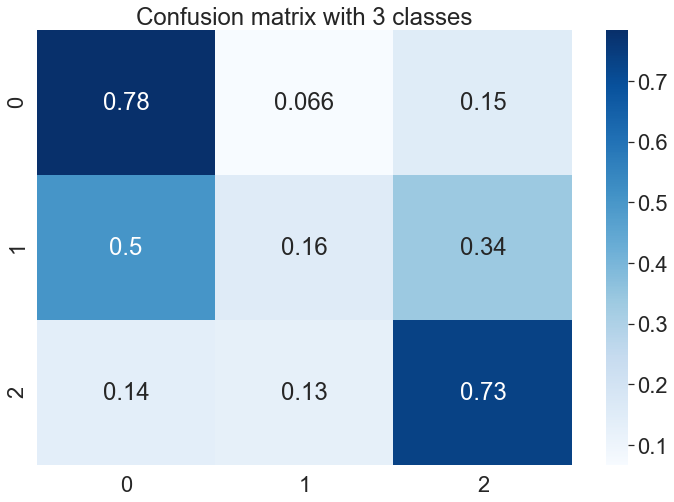

In [368]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
clf_cmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(clf_cmatrix, annot=True, cmap = 'Blues').set(title = 'Confusion matrix with 3 classes');

In [369]:
new_list = list_to_append('Base Logistic Regression', acc, report_df, clf_cmatrix)

In [370]:
model_lists.append(new_list)

In [371]:
model_lists

[['Base Logistic Regression',
  0.60204,
  0.69685,
  0.78319,
  0.7375,
  0.39931,
  0.15562,
  0.22395,
  0.50917,
  0.73292,
  0.60089,
  0.1382,
  0.50474,
  0.12888]]

# Good news and bad news
The bad news is we only have 60 percent accuracy. The good news is we don't have such great results that we're wondering if we did anything wrong. So now we can start tuning the model.

In [372]:
#from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [373]:
param_grid = {"C": [0.001, 0.1, 1, 10, 100]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train) 
logreg_cv.best_params_

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 1}

In [374]:
logreg_cv.best_score_

0.6066335813508451

In [375]:
best_clsfr = LogisticRegression(C=1)
best_clsfr.fit(X_train, y_train)
y_pred = best_clsfr.predict(X_test)

In [376]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.6020445418035779


0  class:
Precision: 0.69685
Recall: 0.78319
F1 Score: 0.73750

1  class:
Precision: 0.39931
Recall: 0.15562
F1 Score: 0.22395

2  class:
Precision: 0.50917
Recall: 0.73292
F1 Score: 0.60089


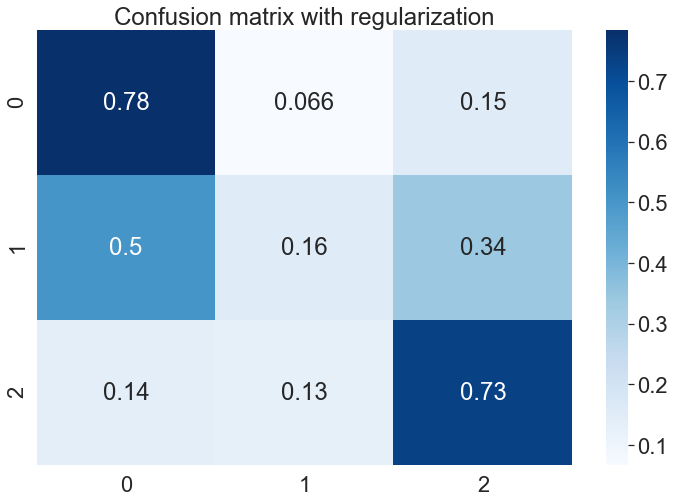

In [377]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
best_clsfr_cmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(best_clsfr_cmatrix, annot=True, cmap = 'Blues').set(title = 'Confusion matrix with regularization');

In [378]:
new_list = list_to_append('Tuned Logistic Regression', acc, report_df, best_clsfr_cmatrix)
model_lists.append(new_list)

# Well that didn't help at all
The tuned model is making the same predictions because 1 is the default value for C anyway in LogisticRegression. We figured those 99.5 accuracy results we originally had were too good to be true. We'll have to move on to more sophisticated models.

In [379]:
from sklearn.ensemble import RandomForestClassifier
base_rf = RandomForestClassifier(random_state = 42)
base_rf.fit(X_train, y_train)
y_pred = base_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc:.5f}")

Accuracy score: 0.59657


In [380]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5965680905439942


0  class:
Precision: 0.70914
Recall: 0.75516
F1 Score: 0.73143

1  class:
Precision: 0.40343
Recall: 0.25440
F1 Score: 0.31203

2  class:
Precision: 0.50905
Recall: 0.65528
F1 Score: 0.57298


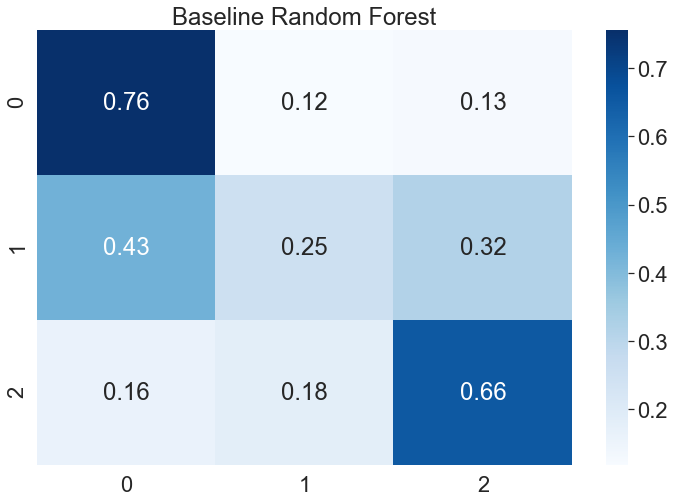

In [381]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
base_rf_cmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(base_rf_cmatrix, annot=True, cmap = 'Blues').set(title = 'Baseline Random Forest');

In [382]:
new_list = list_to_append('Base Random Forest', acc, report_df, base_rf_cmatrix)
model_lists.append(new_list)

# What's different
Overall accuracy is slightly down but can still be rounded up to 60 percent. This model does a better job predicting the 0 (next purchase in more than 96 hours) and 1 (next purchase in 48-96 hours) classes. But the precision and recall are down a little bit for Class 2 (next purchase within 48 hours). We've found that this model has difficulty learning Class 1, maybe because so many samples border this class on both sides. But Class 1 is an important segment to recognize since we expect these customers to purchase again in 2-4 days. Our baseline Random Forest model does a little better predicting that class, but we sacrifice a little when it comes to Class 2 and that class might be even more important. So we'll need to do some tuning.

In [383]:
param_grid = {'n_estimators' : [50, 100, 200], 'max_depth' : [3, 6, 9], 'max_features': ['auto', 'sqrt'],\
             'min_samples_split': [6], 'min_samples_leaf':[1, 2, 3, 4, 5]}

In [384]:
#from sklearn.model_selection import RandomizedSearchCV
# tuned_rf = RandomForestClassifier(random_state = 42)
# rand_grid = GridSearchCV(tuned_rf, param_grid, cv = 3, n_jobs = 2, verbose = 3)
# rand_grid.fit(X_train, y_train)
# print(f"Best Accuracy: {rand_grid.best_score_:.5f}")
# print(f"Best Params: {rand_grid.best_params_}")

In [385]:
best_rf = RandomForestClassifier(n_estimators = 100, min_samples_split = 6, min_samples_leaf = 4,\
                                 max_features = 'auto', max_depth = 9, random_state = 42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
best_rf_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {best_rf_acc:.5f}")

Accuracy score: 0.60606


In [386]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.6060606060606061


0  class:
Precision: 0.71036
Recall: 0.76327
F1 Score: 0.73587

1  class:
Precision: 0.44199
Recall: 0.21651
F1 Score: 0.29064

2  class:
Precision: 0.50543
Recall: 0.72205
F1 Score: 0.59463


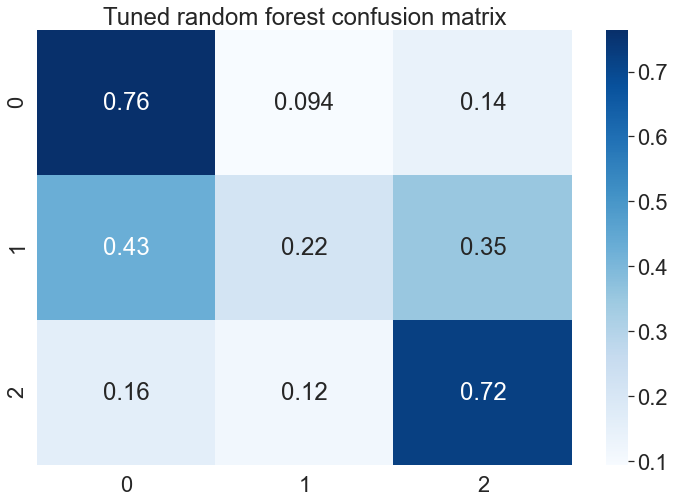

In [387]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
best_rf_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(best_rf_mtx, annot=True, cmap = 'Blues').set(title = 'Tuned random forest confusion matrix');

In [388]:
new_list = list_to_append('Tuned Random Forest', acc, report_df, best_rf_mtx)
model_lists.append(new_list)

The accuracy is up slightly but there's still a lot of tradeoffs with precision and recall. Tuned Random Forest doesn't stand out as a clear winner. We still have some work to do. Let's see what a baseline Naive Bayes model would look like.

In [389]:
from sklearn.naive_bayes import GaussianNB

In [390]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [391]:
print("Naive Bayes score: ",nb.score(X_test, y_test))

Naive Bayes score:  0.5147864184008762


51 percent accuracy. That's no help at all. Forget that.

# XGBoost

In [392]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(random_state = 42)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
print("Accuracy on training set:", xgb_class.score(X_train, y_train))
print("Accuracy on test set:", xgb_class.score(X_test, y_test))

[16:30:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy on training set: 0.9663589422625567
Accuracy on test set: 0.5805038335158818


In [393]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5805038335158818


0  class:
Precision: 0.69376
Recall: 0.73009
F1 Score: 0.71146

1  class:
Precision: 0.38776
Recall: 0.28281
F1 Score: 0.32707

2  class:
Precision: 0.50582
Recall: 0.60714
F1 Score: 0.55187


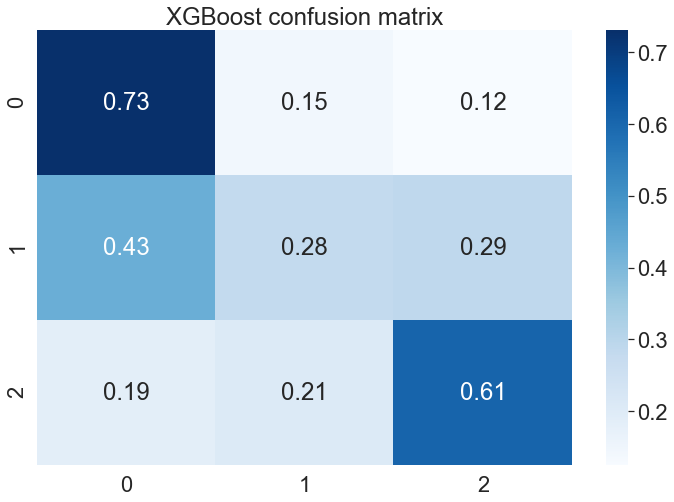

In [395]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
xgbclass_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(xgbclass_mtx, annot=True, cmap = 'Blues').set(title = 'XGBoost confusion matrix');

In [396]:
new_list = list_to_append('Base XG Boost', acc, report_df, xgbclass_mtx)
model_lists.append(new_list)

So we get 58 percent accuracy with default XGBoost. Let's do some tuning.

In [397]:
xgb_params = {'learning_rate' : [0.01, 0.1, 0.5], 'max_depth': [6, 7, 8, 9], 'colsample_bytree': [0.5, 1],\
             'n_estimators': [100, 125, 150, 175, 200, 225, 250]}

In [398]:
# tuned_xgb = xgb.XGBClassifier(random_state = 42)
# xgb_cv = GridSearchCV(tuned_xgb, xgb_params, cv = 3, n_jobs = 2, verbose = 3)
# xgb_cv.fit(X_train, y_train)
# print(f"Best Accuracy: {xgb_cv.best_score_:.5f}")
# print(f"Best Params: {xgb_cv.best_params_}")

In [399]:
best_xgb = xgb.XGBClassifier(n_estimators = 250, max_depth = 6, learning_rate = 0.01, colsample_bytree = 0.5)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print("Accuracy on training set:", best_xgb.score(X_train, y_train))
print("Accuracy on test set:", best_xgb.score(X_test, y_test))

[16:31:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 0.7063057424503207
Accuracy on test set: 0.6166484118291348


In [400]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.6166484118291348


0  class:
Precision: 0.71158
Recall: 0.77507
F1 Score: 0.74197

1  class:
Precision: 0.46216
Recall: 0.23139
F1 Score: 0.30839

2  class:
Precision: 0.52354
Recall: 0.72516
F1 Score: 0.60807


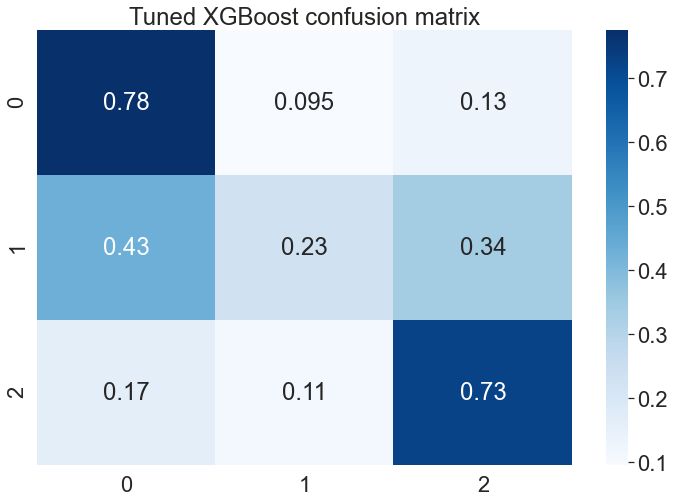

In [401]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
bestxgb_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(bestxgb_mtx, annot=True, cmap = 'Blues').set(title = 'Tuned XGBoost confusion matrix');

In [402]:
new_list = list_to_append('Tuned XG Boost', acc, report_df, bestxgb_mtx)
model_lists.append(new_list)

62 percent accuracy and a better job learning Class 2, but it slips a little with the Class 1 metrics.

# Let's try K Nearest Neighbors

In [403]:
from sklearn.neighbors import KNeighborsClassifier

In [404]:
param_grid = {'n_neighbors': np.arange(1,50)}

In [405]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=3, n_jobs = 2, verbose = 3)
knn_cv.fit(X_train, y_train)
print(f"Best Accuracy: {knn_cv.best_score_:.5f}")
print(f"Best Params: {knn_cv.best_params_}")

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   34.3s


Best Accuracy: 0.57581
Best Params: {'n_neighbors': 18}


[Parallel(n_jobs=2)]: Done 147 out of 147 | elapsed:   43.1s finished


In [406]:
tuned_knn = KNeighborsClassifier(n_neighbors = 18)
tuned_knn.fit(X_train, y_train)
y_pred = tuned_knn.predict(X_test)
print("Accuracy on training set:", tuned_knn.score(X_train, y_train))
print("Accuracy on test set:", tuned_knn.score(X_test, y_test))

Accuracy on training set: 0.625567203880457
Accuracy on test set: 0.5710113179992699


In [407]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)


Accuracy score:
0.5710113179992699


0  class:
Precision: 0.67293
Recall: 0.76622
F1 Score: 0.71655

1  class:
Precision: 0.37662
Recall: 0.23545
F1 Score: 0.28976

2  class:
Precision: 0.47885
Recall: 0.54503
F1 Score: 0.50980


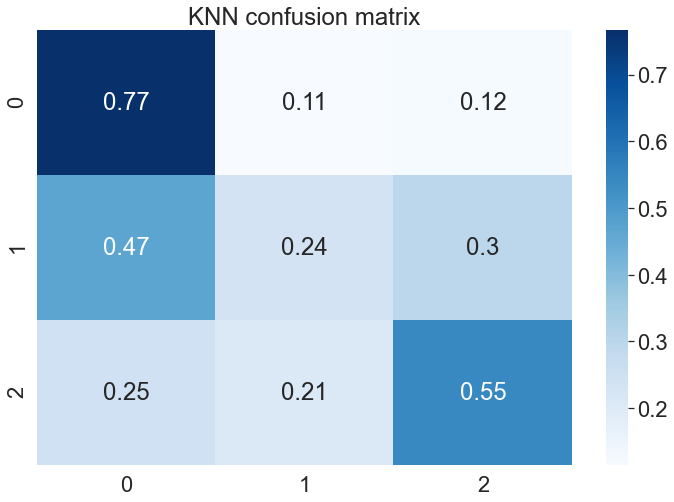

In [408]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
knn_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(knn_mtx, annot=True, cmap = 'Blues').set(title = 'KNN confusion matrix');

In [409]:
new_list = list_to_append('K Nearest Neighbors', acc, report_df, knn_mtx)
model_lists.append(new_list)

# A step in the wrong direction
Accuracy is down with KNN and also we lose a lot of precision and recall with Class 2.

# Dataframe of model results
The last three columns stand for True label 2 predicted as 0, True label 1 predicted as 0, True label 2 predicted as 1

In [410]:
models_df = pd.DataFrame(model_lists, columns = ['Model', 'Accuracy', '0 Precision', '0 Recall', '0 F1 Score',\
                                                '1 Precision', '1 Recall', '1 F1 Score',\
                                                '2 Precision', '2 Recall', '2 F1 Score',\
                                                'T2P0', 'T1P0', 'T2P1'])

In [411]:
models_df

,Model,Accuracy,0 Precision,0 Recall,0 F1 Score,1 Precision,1 Recall,1 F1 Score,2 Precision,2 Recall,2 F1 Score,T2P0,T1P0,T2P1
0,Base Logistic Regression,0.60204,0.69685,0.78319,0.73750,0.39931,0.15562,0.22395,0.50917,0.73292,0.60089,0.13820,0.50474,0.12888
1,Tuned Logistic Regression,0.60204,0.69685,0.78319,0.73750,0.39931,0.15562,0.22395,0.50917,0.73292,0.60089,0.13820,0.50474,0.12888
2,Base Random Forest,0.59657,0.70914,0.75516,0.73143,0.40343,0.25440,0.31203,0.50905,0.65528,0.57298,0.16149,0.42760,0.18323
3,Tuned Random Forest,0.60606,0.71036,0.76327,0.73587,0.44199,0.21651,0.29064,0.50543,0.72205,0.59463,0.16149,0.43031,0.11646
4,Base XG Boost,0.58050,0.69376,0.73009,0.71146,0.38776,0.28281,0.32707,0.50582,0.60714,0.55187,0.18634,0.42896,0.20652
5,Tuned XG Boost,0.61665,0.71158,0.77507,0.74197,0.46216,0.23139,0.30839,0.52354,0.72516,0.60807,0.16615,0.43166,0.10870
6,K Nearest Neighbors,0.57101,0.67293,0.76622,0.71655,0.37662,0.23545,0.28976,0.47885,0.54503,0.50980,0.24845,0.46685,0.20652


In [412]:
models_df.to_csv(r'C:\Users\Owner\Springboard\Starbucks_Capstone\models_df1.csv')

# Next steps
We'll try redistributing the classes. 